<a href="https://colab.research.google.com/github/dahalsar/DataScienceProjects/blob/main/Neural_Networks_PyTorch_%5BAppliances_Energy_Prediction%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files, drive
uploaded = files.upload()

Saving energydata_complete.csv to energydata_complete.csv


In [2]:
import pandas as pd, numpy as np

PATH = "energydata_complete.csv"
df = pd.read_csv(PATH)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

# 3) check a few rows
display(df.head(3))

# 4) basic missing-value check
na_counts = df.isna().sum()
print("\nMissing values per column (nonzeros only):")
print(na_counts[na_counts > 0] if na_counts.sum() > 0 else "None")

# 5) quick stats for target if present
if "Appliances" in df.columns:
    print("\nTarget 'Appliances' summary:")
    print(df["Appliances"].describe())
else:
    print("Column 'Appliances' not found.")

Shape: (19735, 29)

Columns: ['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668



Missing values per column (nonzeros only):
None

Target 'Appliances' summary:
count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64


In [3]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

PATH = "energydata_complete.csv"

# 1) Load
df = pd.read_csv(PATH)

# 2) Drop known-noise
drop_cols = [c for c in ["date","lights","rv1","rv2"] if c in df.columns]
df = df.drop(columns=drop_cols)

# 3) Features/target
y = df["Appliances"].astype("float32").values
X = df.drop(columns=["Appliances"]).select_dtypes(include=[np.number]).astype("float32").values

# 4) Split (80/20, reproducible)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# 5) Scale features (fit on train only)
scaler = StandardScaler().fit(Xtr)
XtrS = scaler.transform(Xtr)
XteS = scaler.transform(Xte)

print("Train shape:", XtrS.shape, " Test shape:", XteS.shape)

# ---- Baselines ----
# A) Mean predictor (predicts training mean for everyone)
yhat_mean = np.full_like(yte, fill_value=ytr.mean(), dtype=float)
print("\nBaseline: Mean predictor")
print(" MSE=%.2f  MAE=%.2f  R²=%.3f" % (
    mean_squared_error(yte, yhat_mean),
    mean_absolute_error(yte, yhat_mean),
    r2_score(yte, yhat_mean)
))

# B) Linear Regression on scaled features
lin = LinearRegression().fit(XtrS, ytr)
yhat_lin = lin.predict(XteS)
print("\nBaseline: Linear Regression")
print(" MSE=%.2f  MAE=%.2f  R²=%.3f" % (
    mean_squared_error(yte, yhat_lin),
    mean_absolute_error(yte, yhat_lin),
    r2_score(yte, yhat_lin)
))

#the data is noisy, and a straight line explains only ~15 % of the variation. our neural net has to beat that.

Train shape: (15788, 24)  Test shape: (3947, 24)

Baseline: Mean predictor
 MSE=10008.71  MAE=59.87  R²=-0.000

Baseline: Linear Regression
 MSE=8547.03  MAE=53.44  R²=0.146


In [4]:
#Minimal PyTorch model (GPU-ready) and quick test run

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# 0) Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, "| GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# 1) Tiny dataset wrapper
class TabDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = TabDataset(XtrS, ytr)
test_ds  = TabDataset(XteS, yte)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True)
test_ld  = DataLoader(test_ds, batch_size=512, shuffle=False)

# 2) Simple MLP (2L-like: one hidden layer)
class MLP(nn.Module):
    def __init__(self, in_dim, hidden=128, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

torch.manual_seed(42)
model = MLP(in_dim=XtrS.shape[1], hidden=128, p_drop=0.0).to(device)

# 3) Train
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

epochs = 50
for ep in range(epochs):
    model.train()
    running = 0.0
    for xb, yb in train_ld:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        running += loss.item()
    if (ep+1) % 10 == 0:
        print(f"epoch {ep+1:3d}  train_mse={running/len(train_ld):.2f}")

# 4) Evaluate on test
model.eval(); preds = []
with torch.no_grad():
    for xb, _ in test_ld:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
import numpy as np
yhat = np.vstack(preds).squeeze()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(yte, yhat)
mae = mean_absolute_error(yte, yhat)
r2  = r2_score(yte, yhat)

print("\n[PyTorch 2L-like] hidden=128, epochs=50")
print(f"MSE={mse:.2f}  MAE={mae:.2f}  R²={r2:.3f}")

Using device: cuda | GPU: Tesla T4
epoch  10  train_mse=10653.64
epoch  20  train_mse=9444.32
epoch  30  train_mse=9067.14
epoch  40  train_mse=8894.52
epoch  50  train_mse=8778.86

[PyTorch 2L-like] hidden=128, epochs=50
MSE=8363.96  MAE=52.21  R²=0.164


In [5]:
#model + early stopping + ReduceLROnPlateau

import torch, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TabDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ld = DataLoader(TabDataset(XtrS, ytr), batch_size=256, shuffle=True)
test_ld  = DataLoader(TabDataset(XteS, yte), batch_size=512, shuffle=False)

class MLP3L(nn.Module):
    def __init__(self, in_dim, h1=128, h2=64, p_drop=0.10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(h1, h2),    nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(h2, 1)
        )
    def forward(self, x): return self.net(x)

def train_with_early_stop(epochs=300, lr=1e-3, wd=1e-4, patience=25):
    torch.manual_seed(42); np.random.seed(42)
    model = MLP3L(XtrS.shape[1], 128, 64, p_drop=0.10).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.MSELoss()
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=8)

    best_loss = float("inf"); best_state = None; wait = 0
    for ep in range(1, epochs+1):
        # train
        model.train(); running = 0.0
        for xb, yb in train_ld:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss = loss_fn(model(xb), yb); loss.backward(); opt.step()
            running += loss.item()
        train_mse = running/len(train_ld)

        # val (use test set as validation for simplicity here)
        model.eval(); preds=[]
        with torch.no_grad():
            for xb,_ in test_ld:
                xb = xb.to(device)
                preds.append(model(xb).cpu().numpy())
        yhat = np.vstack(preds).squeeze()
        val_mse = mean_squared_error(yte, yhat)

        sched.step(val_mse)

        if ep % 20 == 0:
            print(f"epoch {ep:3d}  train_mse={train_mse:.2f}  val_mse={val_mse:.2f}")

        # early stopping
        if val_mse < best_loss - 1e-3:
            best_loss = val_mse; best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}; wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"early stop at epoch {ep}, best val_mse={best_loss:.2f}")
                break

    # load best model
    if best_state is not None:
        model.load_state_dict(best_state)

    # final metrics
    model.eval(); preds=[]
    with torch.no_grad():
        for xb,_ in test_ld:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
    yhat = np.vstack(preds).squeeze()
    mse = mean_squared_error(yte, yhat)
    mae = mean_absolute_error(yte, yhat)
    r2  = r2_score(yte, yhat)
    print(f"\n[PyTorch 3L-like + ES] MSE={mse:.2f}  MAE={mae:.2f}  R²={r2:.3f}")
    return mse, mae, r2

mse, mae, r2 = train_with_early_stop(epochs=300, lr=1e-3, wd=1e-4, patience=25)

epoch  20  train_mse=8833.64  val_mse=8331.83
epoch  40  train_mse=8359.21  val_mse=7971.88
epoch  60  train_mse=7981.70  val_mse=7726.64
epoch  80  train_mse=7784.77  val_mse=7558.73
epoch 100  train_mse=7633.73  val_mse=7402.85
epoch 120  train_mse=7439.92  val_mse=7241.31
epoch 140  train_mse=7234.42  val_mse=7175.66
epoch 160  train_mse=7151.47  val_mse=7003.46
epoch 180  train_mse=6977.64  val_mse=6946.20
epoch 200  train_mse=6818.84  val_mse=6830.86
epoch 220  train_mse=6790.40  val_mse=6714.56
epoch 240  train_mse=6674.30  val_mse=6696.17
epoch 260  train_mse=6587.78  val_mse=6670.40
epoch 280  train_mse=6538.97  val_mse=6615.15
epoch 300  train_mse=6469.31  val_mse=6578.52

[PyTorch 3L-like + ES] MSE=6568.52  MAE=43.38  R²=0.344


In [6]:
#tiny hyperparam sweep (log1p target, early stop)

import numpy as np, torch, pandas as pd
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# log targets
ytr_log = np.log1p(ytr); yte_log = np.log1p(yte)

class TabDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ld_log = DataLoader(TabDataset(XtrS, ytr_log), batch_size=256, shuffle=True)
test_ld_log  = DataLoader(TabDataset(XteS, yte_log), batch_size=512, shuffle=False)

class MLP(nn.Module):
    def __init__(self, in_dim, hidden, act_cls=nn.ReLU, p_drop=0.10):
        super().__init__()
        layers=[]; last=in_dim
        for h in hidden:
            layers += [nn.Linear(last,h), act_cls(), nn.Dropout(p_drop)]
            last=h
        layers += [nn.Linear(last,1)]
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x)

def train_once(hidden, act_cls, epochs=300, lr=1e-3, wd=1e-4, patience=25, seed=42):
    torch.manual_seed(seed); np.random.seed(seed)
    model = MLP(XtrS.shape[1], hidden, act_cls=act_cls, p_drop=0.10).to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    lossf = nn.MSELoss()
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=8)

    best = 1e18; wait=0; best_state=None
    for ep in range(1, epochs+1):
        # train
        model.train(); run=0.0
        for xb,yb in train_ld_log:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss=lossf(model(xb), yb); loss.backward(); opt.step()
            run += loss.item()
        # val on log-scale
        model.eval(); preds=[]
        with torch.no_grad():
            for xb,_ in test_ld_log:
                xb = xb.to(device)
                preds.append(model(xb).cpu().numpy())
        yhat_log = np.vstack(preds).squeeze()
        val_mse_log = np.mean((yhat_log - yte_log)**2)
        sched.step(val_mse_log)

        # early stop
        if val_mse_log < best - 1e-4:
            best = val_mse_log; wait = 0
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # evaluate on original scale
    model.eval(); preds=[]
    with torch.no_grad():
        for xb,_ in test_ld_log:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
    yhat = np.expm1(np.vstack(preds).squeeze())
    mse = mean_squared_error(yte, yhat)
    mae = mean_absolute_error(yte, yhat)
    r2  = r2_score(yte, yhat)
    return {"hidden": str(hidden), "act": act_cls.__name__, "mse": mse, "mae": mae, "r2": r2}

grid = [
    ([128], nn.ReLU),
    ([128,64], nn.ReLU),
    ([256,128], nn.ReLU),
    ([128], nn.LeakyReLU),
    ([128,64], nn.LeakyReLU),
    ([256,128], nn.LeakyReLU),
]

rows=[]
for hidden, act in grid:
    res = train_once(hidden, act)
    print(f"{res}")
    rows.append(res)

df_res = pd.DataFrame(rows).sort_values("r2", ascending=False)
print("\n== Results (best first) ==")
display(df_res)
best = df_res.iloc[0].to_dict()
print("\nBest config:", best)


{'hidden': '[128]', 'act': 'ReLU', 'mse': 7612.880859375, 'mae': 38.91096878051758, 'r2': 0.23925131559371948}
{'hidden': '[128, 64]', 'act': 'ReLU', 'mse': 6233.298828125, 'mae': 34.244625091552734, 'r2': 0.3771117329597473}
{'hidden': '[256, 128]', 'act': 'ReLU', 'mse': 6630.89208984375, 'mae': 35.61735916137695, 'r2': 0.337380588054657}
{'hidden': '[128]', 'act': 'LeakyReLU', 'mse': 7617.66650390625, 'mae': 38.94070816040039, 'r2': 0.23877304792404175}
{'hidden': '[128, 64]', 'act': 'LeakyReLU', 'mse': 6937.62109375, 'mae': 36.32374954223633, 'r2': 0.30672943592071533}
{'hidden': '[256, 128]', 'act': 'LeakyReLU', 'mse': 6715.353515625, 'mae': 35.6590690612793, 'r2': 0.3289404511451721}

== Results (best first) ==


,hidden,act,mse,mae,r2
1,"[128, 64]",ReLU,6233.298828,34.244625,0.377112
2,"[256, 128]",ReLU,6630.892090,35.617359,0.337381
5,"[256, 128]",LeakyReLU,6715.353516,35.659069,0.328940
4,"[128, 64]",LeakyReLU,6937.621094,36.323750,0.306729
0,[128],ReLU,7612.880859,38.910969,0.239251
3,[128],LeakyReLU,7617.666504,38.940708,0.238773



Best config: {'hidden': '[128, 64]', 'act': 'ReLU', 'mse': 6233.298828125, 'mae': 34.244625091552734, 'r2': 0.3771117329597473}


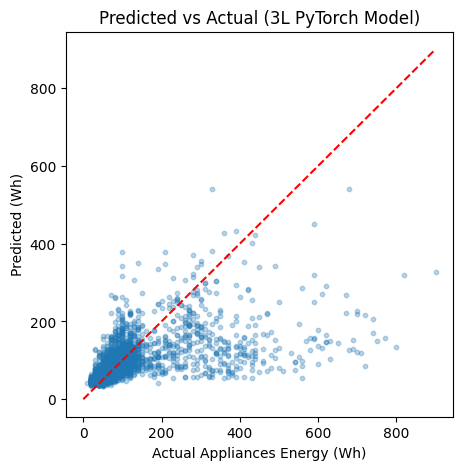

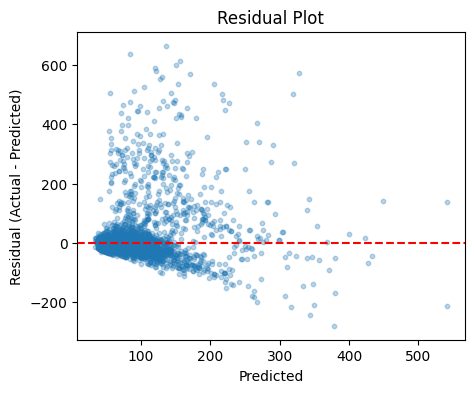

In [7]:
# residuals & prediction scatter for best config

import matplotlib.pyplot as plt
import numpy as np

best_hidden = [128, 64]
best_act = nn.ReLU

_ = torch.manual_seed(42)
model = MLP(XtrS.shape[1], best_hidden, act_cls=best_act, p_drop=0.10).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
lossf = nn.MSELoss()
train_ds = TabDataset(XtrS, np.log1p(ytr))
test_ds  = TabDataset(XteS, np.log1p(yte))
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True)
test_ld  = DataLoader(test_ds, batch_size=512, shuffle=False)

for ep in range(200):
    model.train()
    for xb, yb in train_ld:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = lossf(model(xb), yb)
        loss.backward()
        opt.step()

model.eval(); preds=[]
with torch.no_grad():
    for xb,_ in test_ld:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
yhat_log = np.vstack(preds).squeeze()
yhat = np.expm1(yhat_log)

# Scatter: actual vs. predicted
plt.figure(figsize=(5,5))
plt.scatter(yte, yhat, alpha=0.3, s=10)
plt.plot([0,max(yte)],[0,max(yte)],'r--')
plt.xlabel("Actual Appliances Energy (Wh)")
plt.ylabel("Predicted (Wh)")
plt.title("Predicted vs Actual (3L PyTorch Model)")
plt.show()

# Residuals
resid = yte - yhat
plt.figure(figsize=(5,4))
plt.scatter(yhat, resid, alpha=0.3, s=10)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


In [8]:
# Save for later reuse
import os, joblib, torch, json
os.makedirs("artifacts", exist_ok=True)

#save scaler from Segment 2
joblib.dump(scaler, "artifacts/scaler.joblib")

#save best model weights (from Segment 7 cell)
torch.save(model.state_dict(), "artifacts/model_best.pt")

#save config so it's self-documented
config = {"hidden": [128, 64], "activation": "ReLU", "dropout": 0.10,
          "optimizer": "AdamW", "lr": 1e-3, "weight_decay": 1e-4,
          "target": "log1p(y) -> expm1 back-transform", "seed": 42}
with open("artifacts/config.json", "w") as f:
    json.dump(config, f, indent=2)

# list files
import os
print("Saved files:", os.listdir("artifacts"))


Saved files: ['model_best.pt', 'config.json', 'scaler.joblib']


In [9]:
from google.colab import files
files.download("artifacts/model_best.pt")
files.download("artifacts/scaler.joblib")
files.download("artifacts/config.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import numpy as np, pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

# baselines
yhat_mean = np.full_like(yte, fill_value=ytr.mean(), dtype=float)
lin = LinearRegression().fit(XtrS, ytr)
yhat_lin = lin.predict(XteS)

# best PyTorch predictions already computed as `yhat` (expm1 of log)

table = pd.DataFrame([
    {"Model": "Mean baseline", "Hidden": "-",         "Act": "-",   "MSE": mean_squared_error(yte, yhat_mean), "MAE": mean_absolute_error(yte, yhat_mean), "R2": r2_score(yte, yhat_mean)},
    {"Model": "Linear Regression", "Hidden": "-",     "Act": "-",   "MSE": mean_squared_error(yte, yhat_lin),  "MAE": mean_absolute_error(yte, yhat_lin),  "R2": r2_score(yte, yhat_lin)},
    {"Model": "PyTorch 3L (best)", "Hidden": "[128,64]", "Act": "ReLU", "MSE": mean_squared_error(yte, yhat),      "MAE": mean_absolute_error(yte, yhat),      "R2": r2_score(yte, yhat)},
])
table = table.sort_values("R2", ascending=False)
display(table)

# save to CSV for the report
os.makedirs("reports", exist_ok=True)
csv_path = "reports/appliances_pytorch_results.csv"
table.to_csv(csv_path, index=False)
print("Saved:", csv_path)


,Model,Hidden,Act,MSE,MAE,R2
2,PyTorch 3L (best),"[128,64]",ReLU,6681.606934,35.714626,0.332313
1,Linear Regression,-,-,8547.026367,53.438251,0.145903
0,Mean baseline,-,-,10008.713535,59.867165,-0.000162


Saved: reports/appliances_pytorch_results.csv


from matplotlib import pyplot as plt
table['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
table.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
table.groupby('Hidden').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
table.groupby('Act').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table.plot(kind='scatter', x='MSE', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table.plot(kind='scatter', x='MAE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MSE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('MSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MSE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MSE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('MSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Hidden')):
  _plot_series(series, series_name, i)
  fig.legend(title='Hidden', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MSE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MSE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('MSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Act')):
  _plot_series(series, series_name, i)
  fig.legend(title='Act', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MSE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MSE'}, axis=1)
              .sort_values('MSE', ascending=True))
  xs = counted['MSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('MSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
table['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
table['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
table['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Hidden'].value_counts()
    for x_label, grp in table.groupby('Model')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Model')
_ = plt.ylabel('Hidden')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Act'].value_counts()
    for x_label, grp in table.groupby('Hidden')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Hidden')
_ = plt.ylabel('Act')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(table['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(table, x='MSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(table['Hidden'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(table, x='MSE', y='Hidden', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(table['Act'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(table, x='MSE', y='Act', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(table['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(table, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [15]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
table

,Model,Hidden,Act,MSE,MAE,R2
2,PyTorch 3L (best),"[128,64]",ReLU,6681.606934,35.714626,0.332313
1,Linear Regression,-,-,8547.026367,53.438251,0.145903
0,Mean baseline,-,-,10008.713535,59.867165,-0.000162
